# Importing Basic Libraries

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Importing Dataset

In [103]:
data = pd.read_csv("/kaggle/input/ai-vs-human-text/AI_Human.csv")

In [104]:
data.head(5)

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0
3,How often do you ride in a car? Do you drive a...,0.0
4,Cars are a wonderful thing. They are perhaps o...,0.0


# Values Mapping
###  0 : Human 
###  1 : AI

# Function to Plot the Performance of the model

In [142]:

def plot_graph(history):
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # Create a figure with 1 row and 2 columns

    # Plot training & validation accuracy values
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model accuracy')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model loss')
    ax[1].set_ylabel('Loss')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()


# Exploratory Data Analysis(EDA)

In [106]:
data.generated.value_counts()

generated
0.0    305797
1.0    181438
Name: count, dtype: int64

In [107]:
human_text = data[data['generated']==0]
ai_text = data[data['generated']!=0]

In [108]:
print(human_text.generated.value_counts())
print(ai_text.generated.value_counts())

generated
0.0    305797
Name: count, dtype: int64
generated
1.0    181438
Name: count, dtype: int64


In [109]:
balanced_data = pd.concat([human_text[:25000],ai_text[:25000]],ignore_index=True)


In [110]:
balanced_data.generated.value_counts()

generated
0.0    25000
1.0    25000
Name: count, dtype: int64

In [111]:
balanced_data.head(3)

,text,generated
0,Cars. Cars have been around since they became ...,0.0
1,Transportation is a large necessity in most co...,0.0
2,"""America's love affair with it's vehicles seem...",0.0


In [112]:
# Checking for null values
balanced_data.isnull().sum()

text         0
generated    0
dtype: int64

# Data Preprocessing

In [143]:
import re

In [114]:
def clean_text(text):
    text = re.sub(r'\\n', ' ', text)  # Remove newline characters
    text = re.sub(r'\\', '', text)  # Remove backslashes
    text = re.sub(r'\.{3}', '', text)  # Remove ellipses
    text = re.sub(r'[".,:!]', '', text)  # Remove specific punctuation marks
    text = re.sub(r"(?<!\w)\'|\'(?!\w)", '', text)  # Remove apostrophes that are not part of a word
    text = re.sub(r'\s+', ' ', text)  # Remove extra spaces
    return text


In [115]:
def preprocess_text(text):
    text = text.lower()  # lowercase the text
    return text

In [116]:
balanced_data['text'] = balanced_data['text'].apply(clean_text)

In [117]:
balanced_data['text'] = balanced_data['text'].apply(preprocess_text)

In [118]:
balanced_data.head()   

,text,generated
0,cars cars have been around since they became f...,0.0
1,transportation is a large necessity in most co...,0.0
2,america's love affair with it's vehicles seems...,0.0
3,how often do you ride in a car? do you drive a...,0.0
4,cars are a wonderful thing they are perhaps on...,0.0


# Feature Extraction

In [119]:
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec


In [120]:
nltk.download('punkt')
balanced_data['tokens'] = balanced_data['text'].apply(word_tokenize)


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [121]:
balanced_data.head(3)

,text,generated,tokens
0,cars cars have been around since they became f...,0.0,"[cars, cars, have, been, around, since, they, ..."
1,transportation is a large necessity in most co...,0.0,"[transportation, is, a, large, necessity, in, ..."
2,america's love affair with it's vehicles seems...,0.0,"[america, 's, love, affair, with, it, 's, vehi..."


In [122]:
model = Word2Vec(sentences=balanced_data['tokens'], vector_size=100, window=5, min_count=1, workers=4)

In [123]:
def get_text_vector(tokens):
    valid_tokens = [word for word in tokens if word in model.wv]
    if not valid_tokens:
        return np.zeros(model.vector_size)
    vector = np.mean([model.wv[word] for word in valid_tokens], axis=0)
    return vector


In [124]:
balanced_data['vector'] = balanced_data['tokens'].apply(get_text_vector)

In [125]:
balanced_data.head(3)

,text,generated,tokens,vector
0,cars cars have been around since they became f...,0.0,"[cars, cars, have, been, around, since, they, ...","[0.15599182, 0.39820787, 1.0719395, -0.6690539..."
1,transportation is a large necessity in most co...,0.0,"[transportation, is, a, large, necessity, in, ...","[0.18057534, 0.6238405, 1.1853102, -0.5631129,..."
2,america's love affair with it's vehicles seems...,0.0,"[america, 's, love, affair, with, it, 's, vehi...","[0.22724994, 0.5106203, 0.77144104, -0.4880304..."


# Train Test Split

In [126]:
from sklearn.model_selection import train_test_split


In [127]:
X = balanced_data['vector']
Y = balanced_data['generated']

In [128]:
train_x, test_x , trian_y, test_y= train_test_split(X,Y, test_size=0.2, random_state=42)


In [129]:
train_x=  np.array(train_x.tolist())
test_x=  np.array(test_x.tolist())

In [130]:
X_train = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
X_test = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))

In [131]:
print(X_train.shape)  
print(X_test.shape)   


(40000, 1, 100)
(10000, 1, 100)


# Model Building

## ANN

In [132]:
from keras.models import Sequential
from keras.layers import Dense, Dropout


In [133]:
ann_model = Sequential([
    Dense(128, activation='relu', input_shape=(1,100)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

ann_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
ann_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_14 (Dense)                │ (None, 1, 128)         │        12,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 1, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1, 1)           │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,249 (83.00 KB)

 Trainable params: 21,249 (83.00 KB)

 Non-trainable params: 0 (0.00 B)

In [134]:
ann_history = ann_model.fit(X_train, trian_y, epochs=10, validation_data=(X_test, test_y))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.8894 - loss: 0.2624 - val_accuracy: 0.9698 - val_loss: 0.0851
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9649 - loss: 0.1006 - val_accuracy: 0.9779 - val_loss: 0.0650
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9710 - loss: 0.0843 - val_accuracy: 0.9765 - val_loss: 0.0656
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9739 - loss: 0.0761 - val_accuracy: 0.9798 - val_loss: 0.0571
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9753 - loss: 0.0708 - val_accuracy: 0.9775 - val_loss: 0.0609
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9784 - loss: 0.0632 - val_accuracy: 0.9832 - val_loss: 0.0502
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9795 - loss: 0.0606 - val_accuracy: 0.9839 - val_loss: 0.0461
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9816 - loss: 0.0594 - 

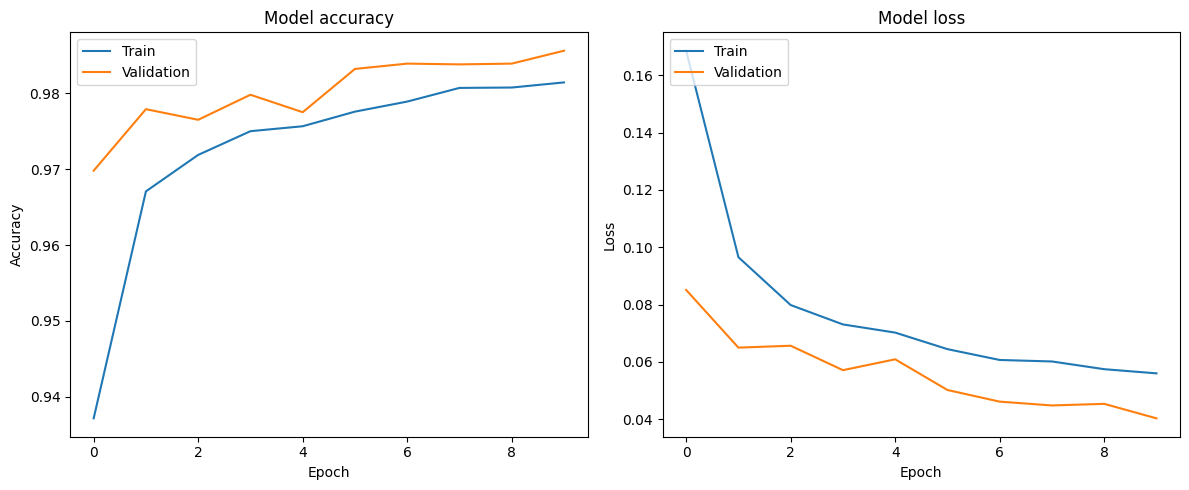

In [140]:
plot_graph(ann_history)

## LSTM

In [144]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional


In [136]:
lstm_model = Sequential([
    LSTM(128, input_shape=(1, 100), return_sequences=True),
    Dropout(0.5),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 1, 128)         │       117,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 1, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,721 (651.25 KB)

 Trainable params: 166,721 (651.25 KB)

 Non-trainable params: 0 (0.00 B)

In [137]:
lstm_history = lstm_model.fit(X_train, trian_y, epochs=10, validation_data=(X_test, test_y))

Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - accuracy: 0.8858 - loss: 0.2589 - val_accuracy: 0.9667 - val_loss: 0.0899
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9644 - loss: 0.1003 - val_accuracy: 0.9740 - val_loss: 0.0709
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9718 - loss: 0.0785 - val_accuracy: 0.9748 - val_loss: 0.0730
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9754 - loss: 0.0657 - val_accuracy: 0.9791 - val_loss: 0.0557
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9780 - loss: 0.0630 - val_accuracy: 0.9796 - val_loss: 0.0559
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9797 - loss: 0.0578 - val_accuracy: 0.9830 - val_loss: 0.0463
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9807 - loss: 0.0543 - val_accuracy: 0.9842 - val_loss: 0.0429
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - accuracy: 0.9800 - loss: 0.0550 - 

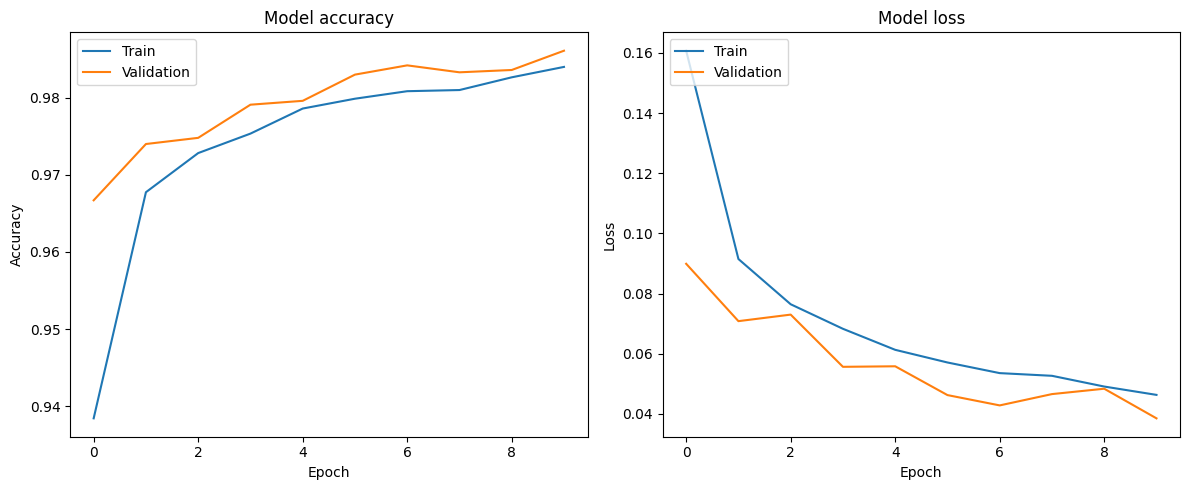

In [141]:
plot_graph(lstm_history)

# Model Evaluation

In [138]:
ann_loss, ann_accuracy = ann_model.evaluate(X_test, test_y)

print(f"ANN Accuracy: {ann_accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9852 - loss: 0.0417
ANN Accuracy: 98.56%


In [139]:
lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test, test_y)

print(f"LSTM Accuracy: {lstm_accuracy * 100:.2f}%")


313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9860 - loss: 0.0400
LSTM Accuracy: 98.61%


### Project Conclusion

#### Overview:
The project aimed to classify text into two categories: AI-generated or human-written. Through comprehensive data preprocessing, feature extraction using Word2Vec, and model building, we analyzed the performance of both Artificial Neural Network (ANN) and Long Short-Term Memory (LSTM) models.

#### Key Findings:

1. **Model Performance:**
   - The ANN and LSTM models exhibited commendable performance in classifying text.
   - The ANN model achieved an accuracy of approximately 98.56%, while the LSTM model achieved around 98.61% accuracy on the test dataset.

2. **Comparative Analysis:**
   - The LSTM model displayed a slight advantage over the ANN model in accuracy.
   - LSTM models, with their capability to capture long-term dependencies, often perform better on text data.

3. **Conclusion:**
   - Both ANN and LSTM models proved effective in the task of classifying text.
   - Depending on specific requirements and computational resources, either model could be chosen for deployment.
   - Notably, transfer learning was not deemed necessary, as the models achieved satisfactory performance without leveraging pre-trained embeddings or models.
